<a href="https://colab.research.google.com/github/pwatana/Neurotech_UofT_2024/blob/main/Neurotech_data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Condensed Step-by-Step Process with Relevant `scipy` imports

1. **Drift Removal**  
   - **Process:** Remove channel drift using a moving average filter. \\
     from scipy.signal import lfilter


2. **Bandpass Filter (1-30 Hz)**  
   - **Process:** Apply a bandpass FIR filter to remove very slow and fast fluctuations.
     \\ from scipy.signal import firwin, filtfilt

3. **Segmentation with Overlapping Windows**  
   - **Process:** Segment data using 3-second overlapping Hamming windows with 90% overlap.
     \\ from scipy.signal import hamming

4. **Autoregressive (AR) Spectrum Estimation**  
   - **Process:** Use a sixth-degree autoregressive model to calculate the frequency spectrum.
     \\ from spectrum import aryule ???

5. **Peak Power and Tremor Detection**  
   - **Process:** Find peaks in the frequency spectrum within the 3–8 Hz range and label tremor windows.
     \\ from scipy.signal import find_peaks

6. **Threshold Filtering for Low-Amplitude Vibrations**  
   - **Process:** Keep tremor-labeled windows with a peak frequency > T.

7. **Upsample Results**  
   - **Process:** Match the length of original accelerometer data by upsampling.
     \\ from scipy.signal import resample

8. **Smoothing to Eliminate Transient Perturbations**  
   - **Process:** Smooth the upsampled data.
     \\ from scipy.ndimage import gaussian_filter1d

9. **Combine Axes (X, Y, Z)**  
   - **Process:** Multiply the results of the three axes to preserve tremor information.



# Install packages and libraries

In [1]:
# imports
import mne
import pickle
import numpy as np

from spectrum import aryule, arma2psd
from scipy import signal
from scipy.signal import find_peaks
from scipy.signal.windows import hamming
from scipy.signal import find_peaks, firwin
from scipy.signal import lfilter
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import windows
from scipy.signal.windows import hamming

Matplotlib is building the font cache; this may take a moment.


Import and visualize data

In [2]:
# import data of single trial
# data imported as numpy array of shape (num_axis,num_timesteps) = (3,93501)

accelerometer_file_path = '/Users/patriciawatanabe/Desktop/Neurotech_UofT_2024/data/accelerometer_data/801_1_accelerometer.pkl'
with open(accelerometer_file_path, 'rb') as f:
    accelerometer_data = pickle.load(f)

accelerometer_data

array([[  623823.4 ,   620121.94,   618349.6 , ...,  -434599.22,
         -435450.38,  -436806.97],
       [ -996951.44,  -997985.  , -1001284.44, ..., -1353972.5 ,
        -1353276.6 , -1351743.  ],
       [ -935598.  ,  -938785.7 ,  -942259.44, ...,  -479022.25,
         -479583.44,  -478910.5 ]], dtype=float32)

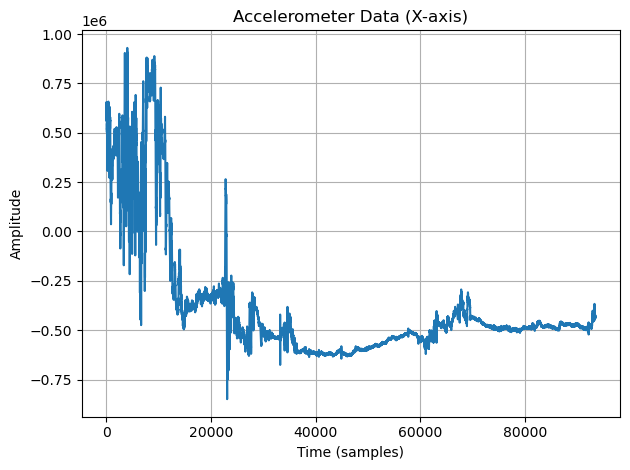

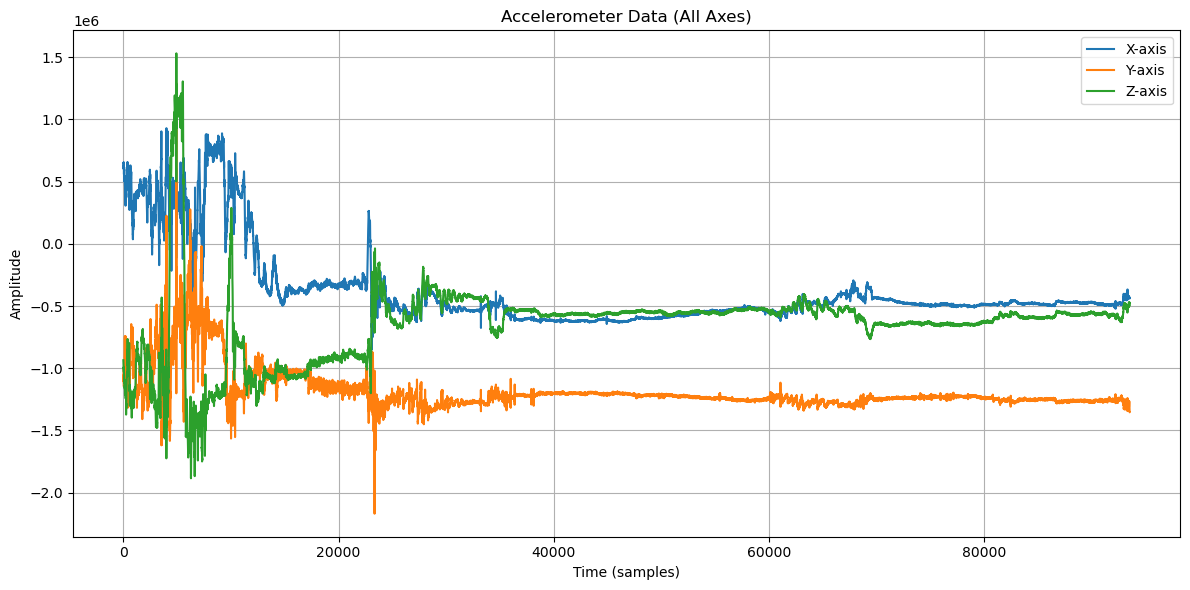

In [3]:
# visualize accelerometer data for one axis

# Create x-axis values for the time indices
# Observe first row
x = list(range(len(accelerometer_data[0])))
plt.plot(x, accelerometer_data[0])
plt.title('Accelerometer Data (X-axis)')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.grid(True)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Plot all axes for visualization
plt.figure(figsize=(12, 6))
axis_labels = ['X-axis', 'Y-axis', 'Z-axis']  # Labels for the axes

for i in range(accelerometer_data.shape[0]):  # Iterate over the rows (axes)
    plt.plot(x, accelerometer_data[i], label=axis_labels[i])  # Plot each axis with a label

# Add plot labels and legend
plt.title('Accelerometer Data (All Axes)')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()  # Show the legend with axis labels
plt.grid(True)  # Add a grid for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()



1. Drift Removal

Moving average filter to smooth out frequencies, window size > 50 would be good?

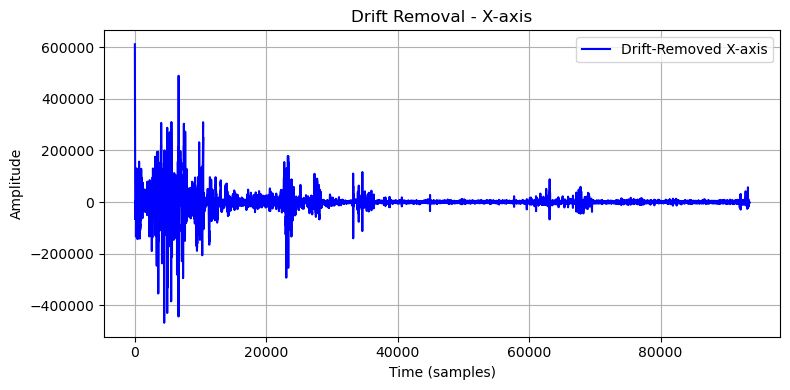

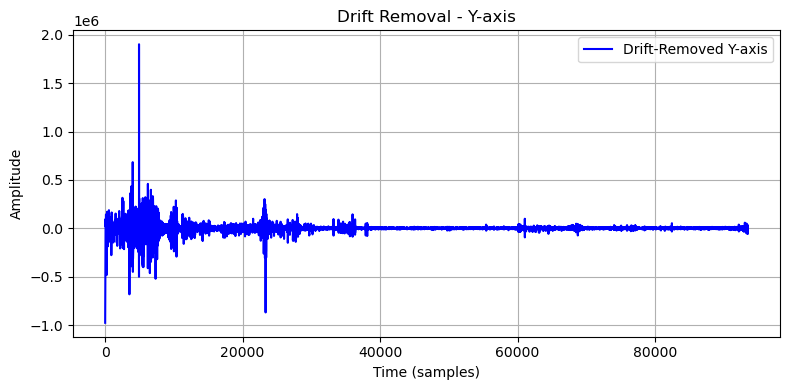

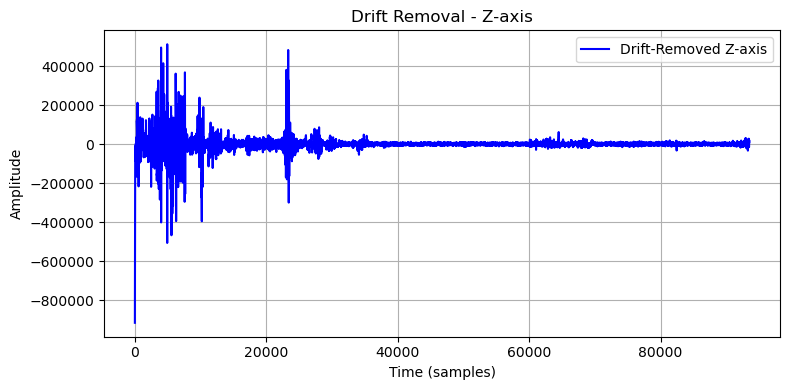

In [4]:
# Define moving average filter
def moving_average_filter(data, window_size=50):
    """
    Removes drift by subtracting a moving average from the signal.
    Args:
        data: 1D array, accelerometer data for one axis.
        window_size: Number of samples for the moving average window.
    Returns:
        Data with drift removed.
    """
    b = np.ones(window_size) / window_size  # Moving average coefficients
    a = [1]  # No feedback
    smoothed_data = lfilter(b, a, data)
    drift_removed = data - smoothed_data  # Subtract moving average from original data
    return drift_removed

# Example application
drift_removed_data = []

for axis_data in accelerometer_data:  # Loop over X, Y, Z axes
    filtered_axis = moving_average_filter(axis_data, window_size=50)
    drift_removed_data.append(filtered_axis)

# Convert back to NumPy array
drift_removed_data = np.array(drift_removed_data)

# Plot all axes after drift removal
# Labels for the axes
axis_labels = ['X-axis', 'Y-axis', 'Z-axis']

# Loop through each axis and plot them separately
for i, label in enumerate(axis_labels):  # Iterate through axes and their labels
    plt.figure(figsize=(8, 4))  # Adjust figure size
    plt.plot(drift_removed_data[i], label=f'Drift-Removed {label}', color='blue')
    plt.title(f"Drift Removal - {label}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)  # Add grid for better visualization
    plt.tight_layout()  # Prevent overlapping of elements
    plt.show()

2. Bandpass Filtering

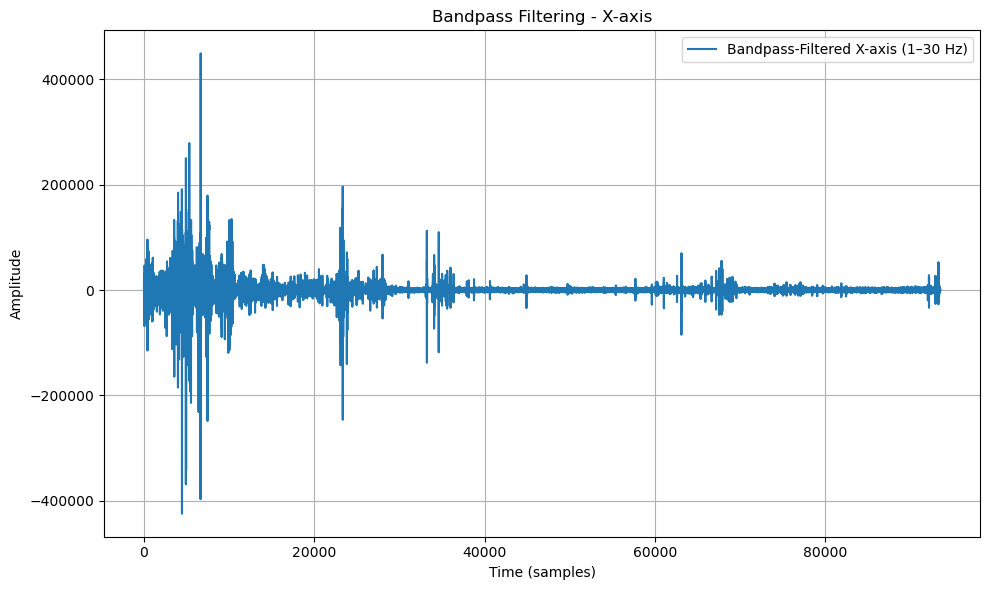

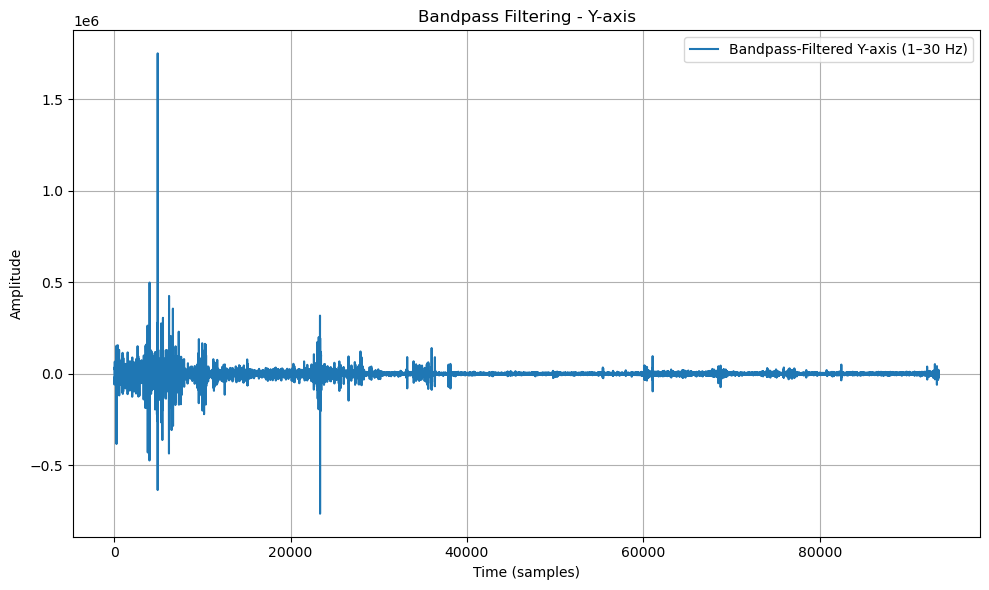

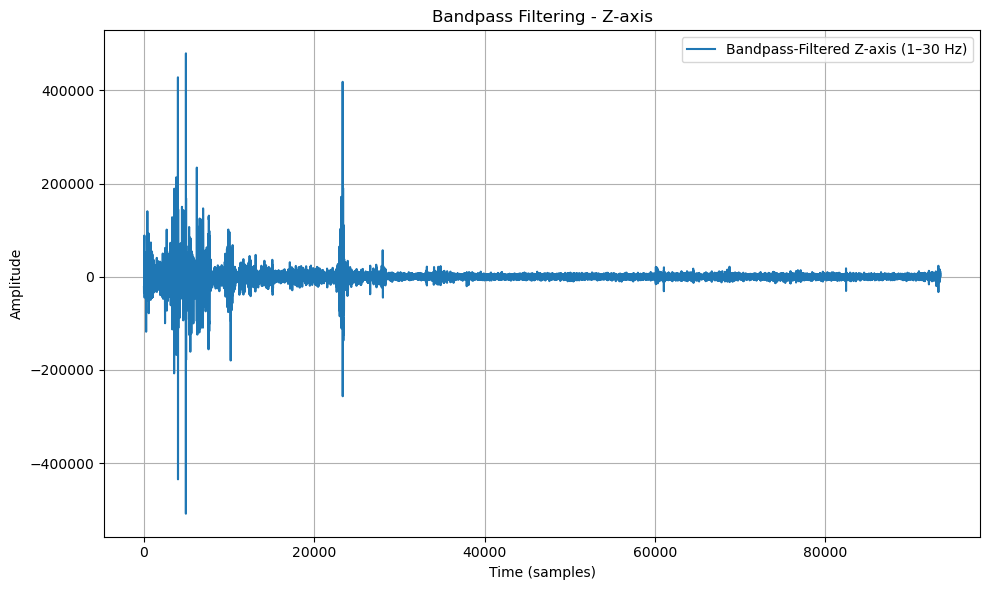

In [7]:
# Filters out irrelevant frequency components. This step isolates the frequency range (1–30 Hz) where the tremors are likely to occur, eliminating slow baseline trends and high-frequency noise.
# So our objective is to - remove any frequency above 30Hz and below 1Hz, only keep 1-30Hz which is what we are interested
# For this we use bandpass filter which is an amazing function because it does exactly what we want:
# It keeps only the frequencies between two specified cutoff frequencies (1–30 Hz) and removes everything else.

# Define bandpass_filter function
def bandpass_filter(data, fs, lowcut, highcut, numtaps=101):
    """
    Bandpass filter using FIR (finite impulse response) filter with firwin.

    Args:
        data: 1D array of the signal to filter (e.g., accelerometer or EEG data).
        fs: Sampling frequency in Hz.
        lowcut: Lower cutoff frequency in Hz.
        highcut: Upper cutoff frequency in Hz.
        numtaps: Number of filter taps (higher value = sharper frequency cutoff).

    Returns:
        Filtered data with only frequencies in the [lowcut, highcut] range.
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist  # Normalize lower cutoff
    high = highcut / nyquist  # Normalize upper cutoff

    # Design the FIR bandpass filter
    taps = firwin(numtaps, [low, high], pass_zero=False)  # Bandpass filter

    # Apply the filter to the data using filtfilt for zero phase distortion
    filtered_data = filtfilt(taps, [1.0], data)
    return filtered_data

# Example application
fs = 100  # Sampling frequency (Hz)
lowcut = 1  # Lower bound of the bandpass filter (Hz)
highcut = 30  # Upper bound of the bandpass filter (Hz)

# Apply bandpass filter to all axes (X, Y, Z)
bandpass_filtered_data = []
for axis_data in drift_removed_data:  # Use drift-removed data as input
    filtered_axis = bandpass_filter(axis_data, fs, lowcut, highcut, numtaps=101)
    bandpass_filtered_data.append(filtered_axis)

# Convert back to NumPy array
bandpass_filtered_data = np.array(bandpass_filtered_data)

# Plotting the result for the first axis
# Labels for the axes (e.g., X, Y, Z)
axis_labels = ['X-axis', 'Y-axis', 'Z-axis']

# Loop through each axis and plot separately
for i, label in enumerate(axis_labels):  # Loop over indices and labels
    plt.figure(figsize=(10, 6))  # Create a new figure for each axis
    plt.plot(bandpass_filtered_data[i], label=f"Bandpass-Filtered {label} (1–30 Hz)")
    plt.title(f"Bandpass Filtering - {label}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)  # Add a grid
    plt.tight_layout()  # Adjust layout
    plt.show()

# Important things to note here is that: this chunk of code error is totally dependent on the value of the parameters you set,
# especially fs, that is used to normalize the lowcut and highcut values upon setting the nyquist
# this normalization is necessary and has the rule 0<normalized lowcut<normalized highcut<nyquist frequency
# nyquist frequency is fs/2 and is the highest frequency that can be accurately captured when sampling a signal
# and this is equal to the half of the sampling rate fs
# so basically it represents the highest frequency that can be repersented without distortion (aliasing)
# which is very important to understand when dealing with our data

# The bandpass filtering seems to have worked nicely! You can see it in the graph, we got rid of the
# extremely high or low frequencies and the baseline is even more stable compared to just having the moving average
# and just from the visualization, I don't think we have some extremely high or low frequency that interfere with the
# stability of our baseline or the consistent amplitude change (maybe we could check but I will do this some other time)

3. Windowing with hamming function

Segmented Signal Shape (axes x windows x samples): (3, 3214, 300)


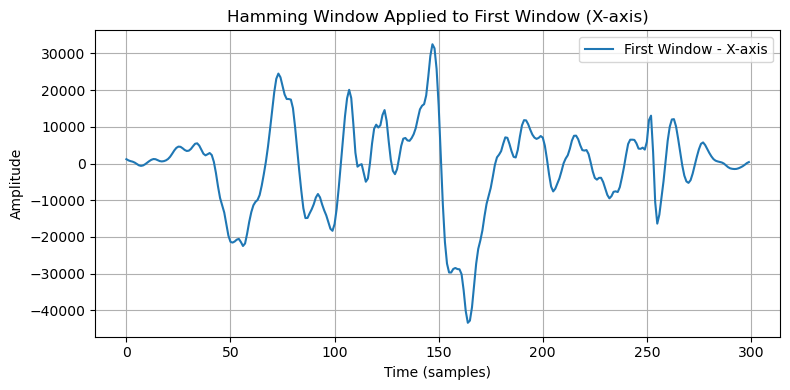

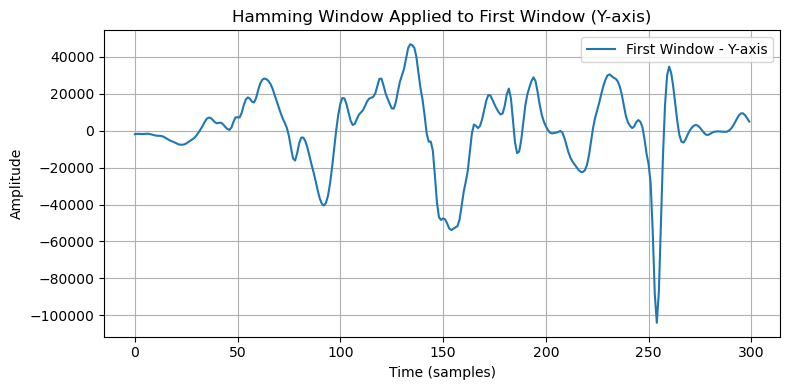

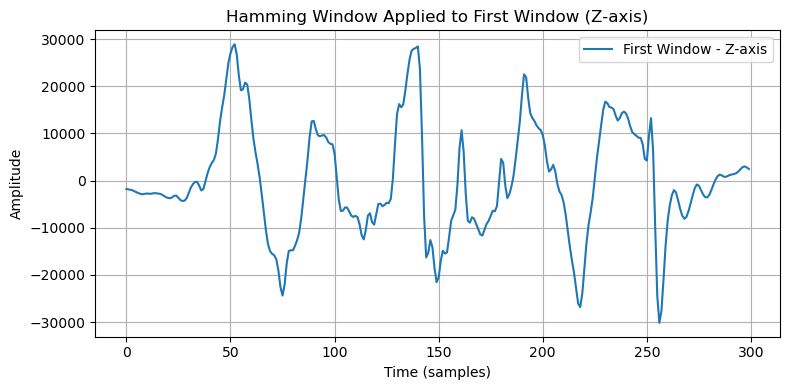

In [8]:
# Segments the signal into overlapping windows for localized analysis. The Hamming window emphasizes central samples, a common technique to minimize spectral leakage in the frequency domain.

# define segments with hamming function
def segment_with_hamming(signal, window_size, overlap, fs):
    """
    Segments the signal into overlapping windows and applies a Hamming window.

    Args:
        signal: 1D array, input signal (e.g., bandpass-filtered data).
        window_size: Duration of each window in seconds.
        overlap: Fraction of overlap between windows (e.g., 0.5 for 50% overlap).
        fs: Sampling frequency in Hz.

    Returns:
        A 2D array of segmented and windowed data, where each row is a window.
    """
    samples_per_window = int(window_size * fs)  # Convert window size to samples
    step_size = int(samples_per_window * (1 - overlap))  # Step size for overlapping
    hamming_window = windows.hamming(samples_per_window)  # Hamming window

    # Create windows
    num_windows = (len(signal) - samples_per_window) // step_size + 1
    segments = np.array([
        signal[i:i + samples_per_window] * hamming_window
        for i in range(0, len(signal) - samples_per_window + 1, step_size)
    ])

    return segments

# Parameters
fs = 100  # Sampling frequency (Hz)
window_size = 3  # Window duration in seconds
overlap = 0.9  # 90% overlap

# Apply segmentation to all axes
segmented_signals = []  # To store segmented signals for all axes
for axis_data in bandpass_filtered_data:
    segmented_axis = segment_with_hamming(axis_data, window_size, overlap, fs)
    segmented_signals.append(segmented_axis)

# Convert the segmented signals list to a NumPy array for easier handling
segmented_signals = np.array(segmented_signals)  # Shape: (3, num_windows, window_size * fs)

# Check the shape of the result
print("Segmented Signal Shape (axes x windows x samples):", segmented_signals.shape)

# Visualization for each axis
axis_labels = ['X-axis', 'Y-axis', 'Z-axis']
for i, label in enumerate(axis_labels):
    plt.figure(figsize=(8, 4))
    plt.plot(segmented_signals[i][0], label=f"First Window - {label}")
    plt.title(f"Hamming Window Applied to First Window ({label})")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



4. Frequency Spectrum Calculation (6th-Oder Autoregressive Modeling Using Berg Method)

In [10]:
from spectrum import aryule, arma2psd
import numpy as np

def detect_dominant_frequency_with_ar(window, fs, low_freq=3, high_freq=8, ar_order=6):
    """
    Detects the dominant frequency and its power in the 3–8 Hz tremor range for a single segment using AR modeling.

    Args:
        window: 1D array, a segment of the signal (e.g., Hamming-windowed).
        fs: Sampling frequency in Hz.
        low_freq: Lower bound of the tremor frequency range (Hz).
        high_freq: Upper bound of the tremor frequency range (Hz).
        ar_order: Order of the autoregressive model.

    Returns:
        dominant_frequency: The frequency with the highest power in the 3–8 Hz range, or None if no peak is found.
        dominant_power: The power at the dominant frequency, or 0 if no peak is found.
    """
    # Step 1: Estimate AR coefficients using the Burg method
    ar_coeffs, _, _ = aryule(window, ar_order)

    # Step 2: Compute the power spectral density (PSD) from AR coefficients
    psd = arma2psd(ar_coeffs, NFFT=len(window), sides='centerdc')
    psd = np.abs(psd)  # Ensure PSD is non-negative

    # Step 3: Generate corresponding frequency bins
    freq_bins = np.fft.fftfreq(len(psd), d=1 / fs)

    # Step 4: Filter PSD within the 3–8 Hz tremor range
    valid_indices = np.where((freq_bins >= low_freq) & (freq_bins <= high_freq))
    freq_filtered = freq_bins[valid_indices]
    psd_filtered = psd[valid_indices]

    # Step 5: Identify the dominant frequency and its power
    if len(psd_filtered) > 0:
        peak_index = np.argmax(psd_filtered)
        dominant_frequency = freq_filtered[peak_index]
        dominant_power = psd_filtered[peak_index]
    else:
        dominant_frequency = None  # No valid peak found
        dominant_power = 0

    return dominant_frequency, dominant_power

def process_segments_for_dominant_frequencies(segmented_windows, fs, low_freq=3, high_freq=8, ar_order=6):
    """
    Processes all segmented windows for one axis and extracts dominant frequencies and their powers.

    Args:
        segmented_windows: 2D array (windows x samples), segmented signal for one axis.
        fs: Sampling frequency in Hz.
        low_freq: Lower bound of the tremor frequency range (Hz).
        high_freq: Upper bound of the tremor frequency range (Hz).
        ar_order: Order of the autoregressive model.

    Returns:
        dominant_frequencies: 1D array of dominant frequencies for each segment.
        dominant_powers: 1D array of powers corresponding to the dominant frequencies.
    """
    dominant_frequencies = []
    dominant_powers = []
    for window in segmented_windows:
        freq, power = detect_dominant_frequency_with_ar(window, fs, low_freq, high_freq, ar_order)
        dominant_frequencies.append(freq if freq is not None else 0)
        dominant_powers.append(power)

    return np.array(dominant_frequencies), np.array(dominant_powers)



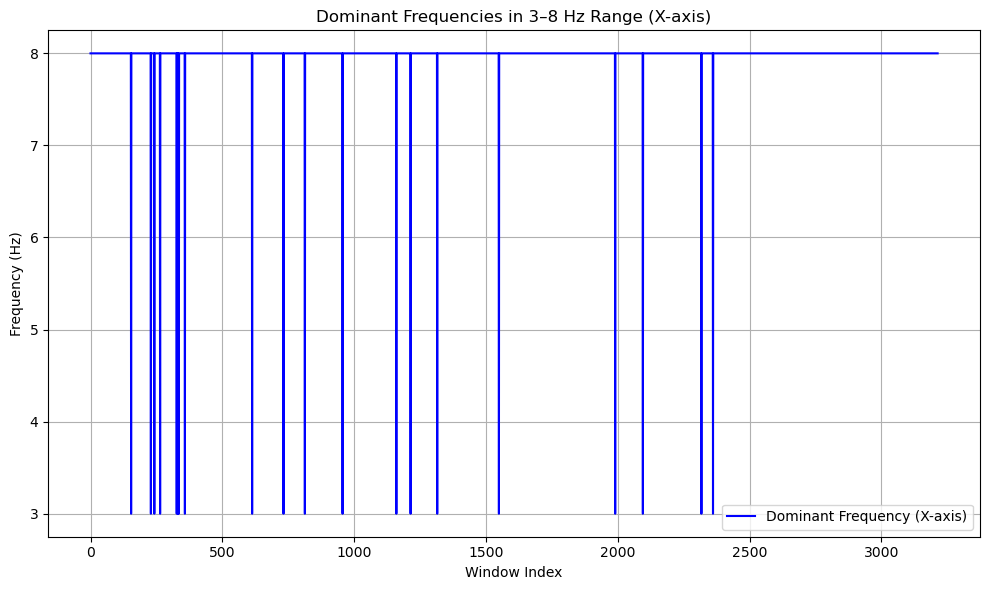

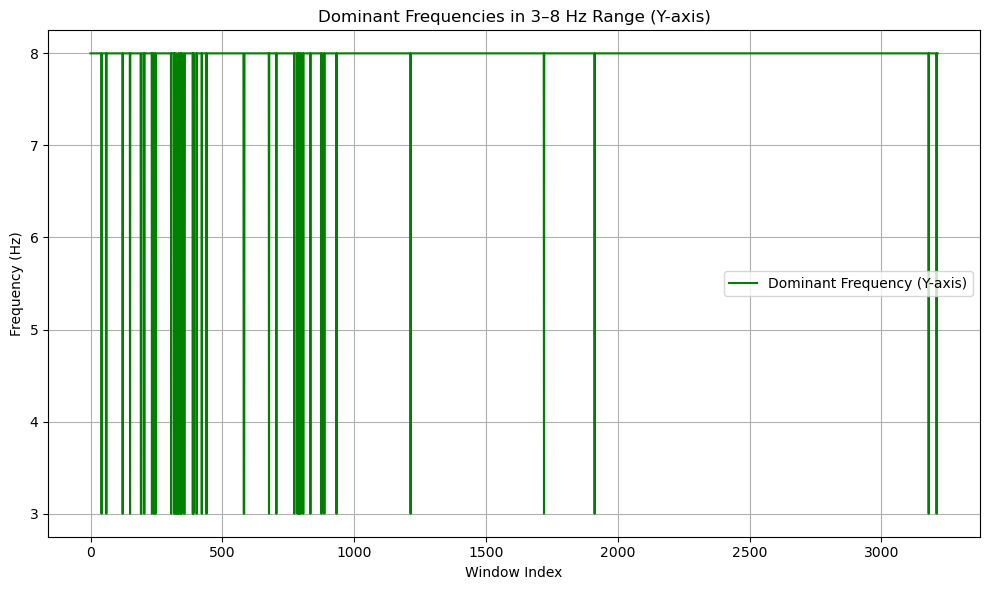

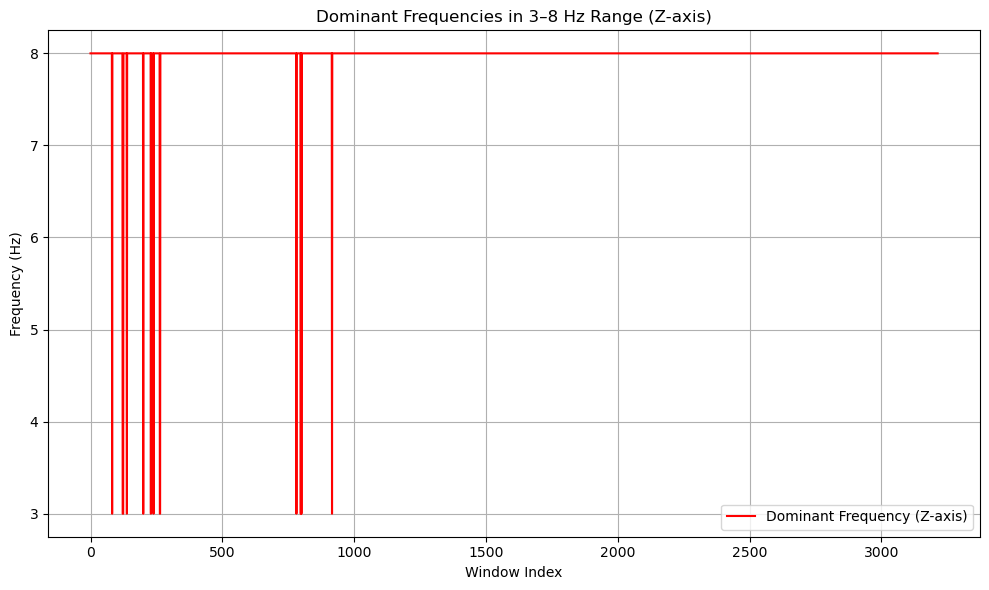

In [14]:
# Example usage for one axis
segmented_windows_x = segmented_signals[0]  # Segmented windows for the X-axis
fs = 100  # Sampling frequency in Hz
low_freq = 3  # Tremor lower bound
high_freq = 8  # Tremor upper bound
ar_order = 6  # AR model order

# Process segments for X-axis
dominant_frequencies_x, dominant_powers_x = process_segments_for_dominant_frequencies(
    segmented_windows_x, fs, low_freq, high_freq, ar_order
)

# Repeat for all axes
dominant_frequencies_all_axes = []
dominant_powers_all_axes = []

for axis_segmented_windows in segmented_signals:
    freqs, powers = process_segments_for_dominant_frequencies(
        axis_segmented_windows, fs, low_freq, high_freq, ar_order
    )
    dominant_frequencies_all_axes.append(freqs)
    dominant_powers_all_axes.append(powers)

# Convert to NumPy arrays for consistency
dominant_frequencies_all_axes = np.array(dominant_frequencies_all_axes)  # Shape: (3, num_windows)
dominant_powers_all_axes = np.array(dominant_powers_all_axes)  # Shape: (3, num_windows)

# Visualize dominant frequencies for all axis
axis_labels = ['X-axis', 'Y-axis', 'Z-axis']
colors = ['blue', 'green', 'red']
for i, label in enumerate(axis_labels):
    plt.figure(figsize=(10, 6))
    plt.plot(dominant_frequencies_all_axes[i], label=f"Dominant Frequency ({label})", color=colors[i])
    plt.title(f"Dominant Frequencies in 3–8 Hz Range ({label})")
    plt.xlabel("Window Index")
    plt.ylabel("Frequency (Hz)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


5. Peak Power Calculation and Thresholding - Frequency domain analysis

In [ ]:
def detect_and_label_tremor_segments(segmented_windows, fs, low_freq=3, high_freq=8, threshold_divisor=10):
    """
    Detects and labels tremor segments based on peak power in the 3–8 Hz range exceeding a threshold.

    Args:
        segmented_windows: List of 1D arrays, each representing a windowed segment of the signal.
        fs: Sampling frequency in Hz.
        low_freq: Lower bound of the tremor frequency range (Hz).
        high_freq: Upper bound of the tremor frequency range (Hz).
        threshold_divisor: Divisor for calculating the peak power threshold.

    Returns:
        tremor_labels: 1D array of binary labels (1 for tremor, 0 for non-tremor).
    """
    tremor_labels = []  # To store binary labels for each segment

    for segment in segmented_windows:
        # Step 1: Compute FFT and Power Spectrum
        N = len(segment)  # Number of samples in the window
        freq_bins = np.fft.fftfreq(N, d=1/fs)  # Frequency bins (Hz)
        fft_values = np.fft.fft(segment)  # FFT values (complex numbers)
        power_spectrum = np.abs(fft_values) ** 2  # Power spectrum (magnitude squared)

        # Step 2: Filter frequencies in the 3–8 Hz tremor range
        valid_indices = np.where((freq_bins >= low_freq) & (freq_bins <= high_freq))
        power_spectrum_filtered = power_spectrum[valid_indices]

        # Step 3: Apply thresholding and label the segment
        if len(power_spectrum_filtered) > 0:
            max_peak_power = np.max(power_spectrum)  # Maximum peak power across all frequencies
            threshold = max_peak_power / threshold_divisor

            # Check if peak power in the 3–8 Hz range exceeds the threshold
            if np.max(power_spectrum_filtered) > threshold:
                tremor_labels.append(1)  # Tremor detected
            else:
                tremor_labels.append(0)  # Non-tremor segment
        else:
            tremor_labels.append(0)  # No valid power in the 3–8 Hz range

    return np.array(tremor_labels)


In [ ]:
# Assume segmented_signals contains the segmented windows for all three axes
segmented_windows_x = segmented_signals[0]  # Segments for X-axis
segmented_windows_y = segmented_signals[1]  # Segments for Y-axis
segmented_windows_z = segmented_signals[2]  # Segments for Z-axis

fs = 100  # Sampling frequency in Hz
low_freq = 3  # Tremor frequency lower bound
high_freq = 8  # Tremor frequency upper bound

# Detect and label tremor for each axis
tremor_labels_x = detect_and_label_tremor_segments(segmented_windows_x, fs, low_freq, high_freq)
tremor_labels_y = detect_and_label_tremor_segments(segmented_windows_y, fs, low_freq, high_freq)
tremor_labels_z = detect_and_label_tremor_segments(segmented_windows_z, fs, low_freq, high_freq)

# Combine labels across axes (optional for downstream steps)
# For example, a tremor is present if detected in any of the axes
combined_tremor_labels = np.logical_or.reduce([tremor_labels_x, tremor_labels_y, tremor_labels_z]).astype(int)

# Print the combined labels
print("Combined Tremor Labels:", combined_tremor_labels)

# Plot tremor labels for one axis (e.g., X-axis)
time = np.arange(len(tremor_labels_x))  # Time indices corresponding to segments
plt.figure(figsize=(10, 6))
plt.stem(time, tremor_labels_x, linefmt="blue", markerfmt="bo", basefmt="r-", label="Tremor Detection")
plt.title("Tremor Detection Labels for X-axis")
plt.xlabel("Segment Index")
plt.ylabel("Tremor Label (1=Tremor, 0=Non-Tremor)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


6. Axis Combination Using Multiplication
(changing from Time-Frequency Representation)

In [ ]:
def combine_axes_with_multiplication(filtered_signals):
    """
    Combines signals from multiple axes (e.g., X, Y, Z) using element-wise multiplication.

    Args:
        filtered_signals: 2D array (axes x time), e.g., [X_filtered, Y_filtered, Z_filtered].
                         Each row represents the processed signal for one axis.

    Returns:
        combined_signal: 1D array, the combined signal across axes.
    """
    # Element-wise multiplication across axes
    combined_signal = np.prod(filtered_signals, axis=0)
    return combined_signal

# Example usage
# Assume these are the processed signals from the X, Y, Z axes after peak power and thresholding
processed_signals = np.array([
    x_filtered_signal,  # Replace with the processed X-axis signal
    y_filtered_signal,  # Replace with the processed Y-axis signal
    z_filtered_signal   # Replace with the processed Z-axis signal
])

# Combine signals across axes
combined_signal = combine_axes_with_multiplication(processed_signals)

# Visualization of the combined signal
import matplotlib.pyplot as plt
time = np.arange(len(combined_signal))  # Replace with actual time values
plt.figure(figsize=(10, 6))
plt.plot(time, combined_signal, label="Combined Signal", color="blue")
plt.title("Combined Signal (X * Y * Z)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


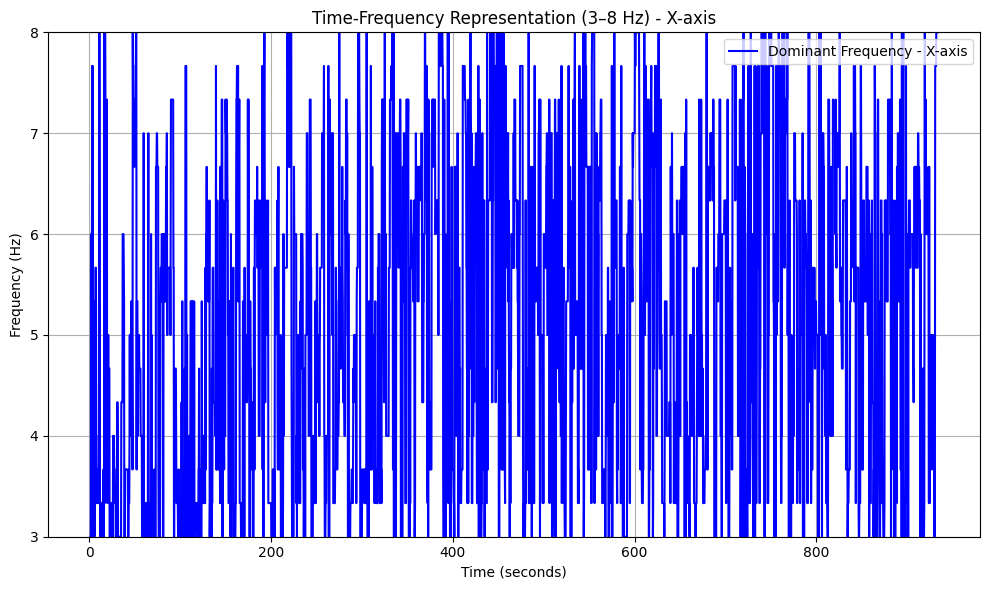

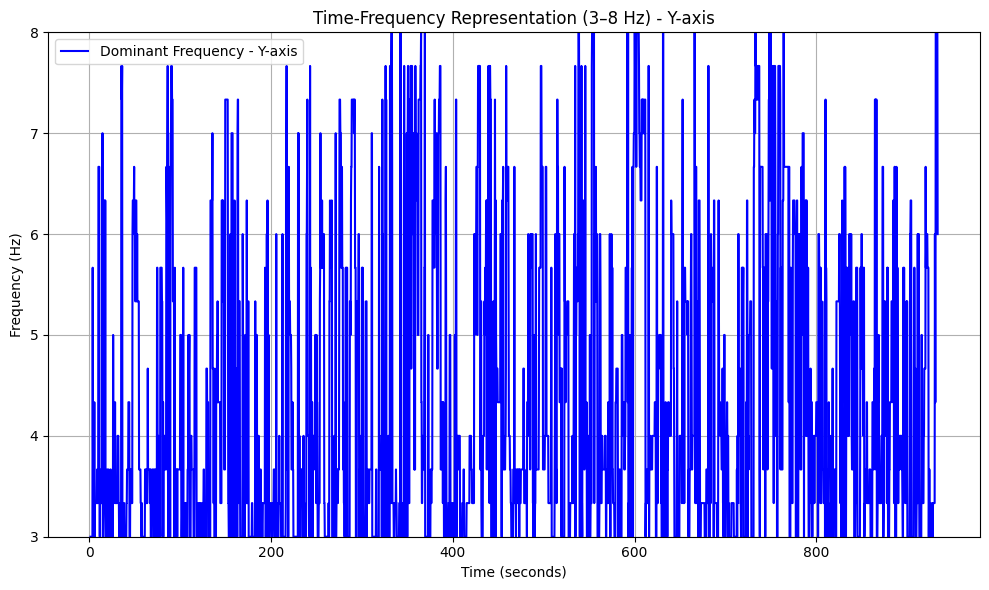

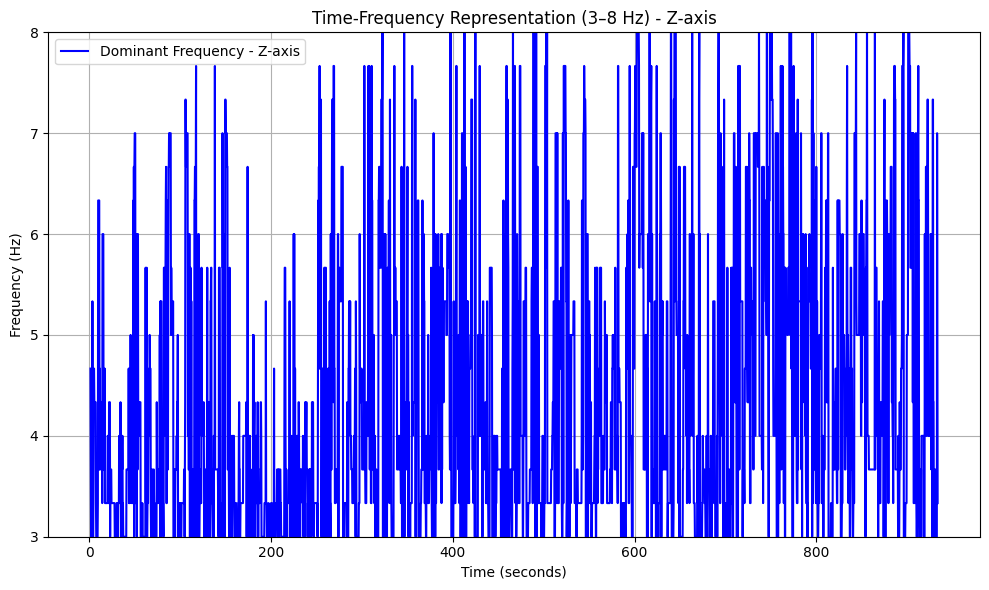

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

def time_frequency_representation_all_axes(signals, fs, low_freq=3, high_freq=8, nperseg=300, noverlap=270):
    """
    Computes the Time-Frequency Representation for each axis and extracts the dominant frequency
    in the 3–8 Hz range for each time window.

    Args:
        signals: 2D array (axes x time), e.g., [X, Y, Z].
        fs: Sampling frequency in Hz.
        low_freq: Lower bound of the tremor frequency range (Hz).
        high_freq: Upper bound of the tremor frequency range (Hz).
        nperseg: Number of samples per segment.
        noverlap: Number of overlapping samples.

    Returns:
        time_bins: Array of time bins.
        dominant_frequencies_all_axes: 2D array where each row contains the dominant frequencies for an axis.
    """
    dominant_frequencies_all_axes = []
    time_bins = None  # To store shared time bins for all axes

    for axis_signal in signals:
        # Compute the spectrogram (STFT) for this axis
        f, t, Sxx = spectrogram(axis_signal, fs, nperseg=nperseg, noverlap=noverlap, scaling='density')

        # Filter frequencies in the 3–8 Hz range
        valid_indices = np.where((f >= low_freq) & (f <= high_freq))
        f_filtered = f[valid_indices]
        Sxx_filtered = Sxx[valid_indices, :][0]  # Keep only rows for valid frequencies

        # Extract the dominant frequency (peak power) for each time window
        dominant_frequencies = []
        for i in range(Sxx_filtered.shape[1]):
            if np.max(Sxx_filtered[:, i]) > 0:  # Check if there’s any valid power
                peak_index = np.argmax(Sxx_filtered[:, i])
                dominant_frequencies.append(f_filtered[peak_index])
            else:
                dominant_frequencies.append(0)  # No significant frequency detected

        dominant_frequencies_all_axes.append(dominant_frequencies)
        if time_bins is None:  # Set time bins from the first axis
            time_bins = t

    return time_bins, np.array(dominant_frequencies_all_axes)

# Example usage
fs = 100  # Sampling frequency in Hz
low_freq = 3  # Lower tremor range bound (Hz)
high_freq = 8  # Upper tremor range bound (Hz)
nperseg = 300  # Number of samples per segment
noverlap = 270  # Overlap between segments

# Use the bandpass-filtered signals for all axes (X, Y, Z)
signals = bandpass_filtered_data  # Replace with actual data (shape: 3 x time)

# Compute Time-Frequency Representation for all axes
time_bins, dominant_frequencies_all_axes = time_frequency_representation_all_axes(
    signals, fs, low_freq, high_freq, nperseg, noverlap
)

# Visualization for each axis
axis_labels = ['X-axis', 'Y-axis', 'Z-axis']
for i, label in enumerate(axis_labels):
    plt.figure(figsize=(10, 6))
    plt.plot(time_bins, dominant_frequencies_all_axes[i], label=f"Dominant Frequency - {label}", color="blue")
    plt.title(f"Time-Frequency Representation (3–8 Hz) - {label}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Frequency (Hz)")
    plt.ylim(low_freq, high_freq)  # Focus on tremor range
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


7. Signal smoothing

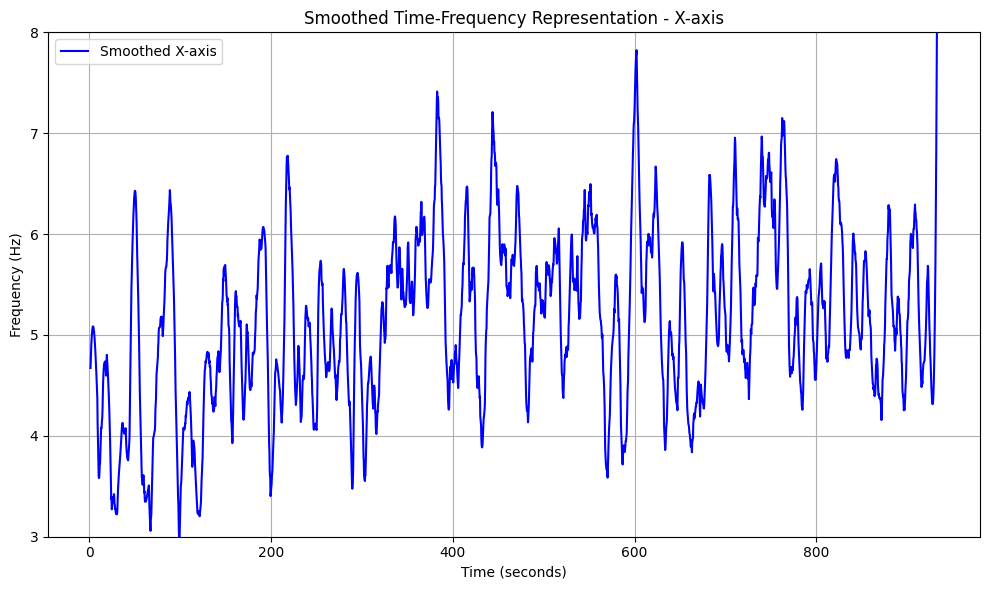

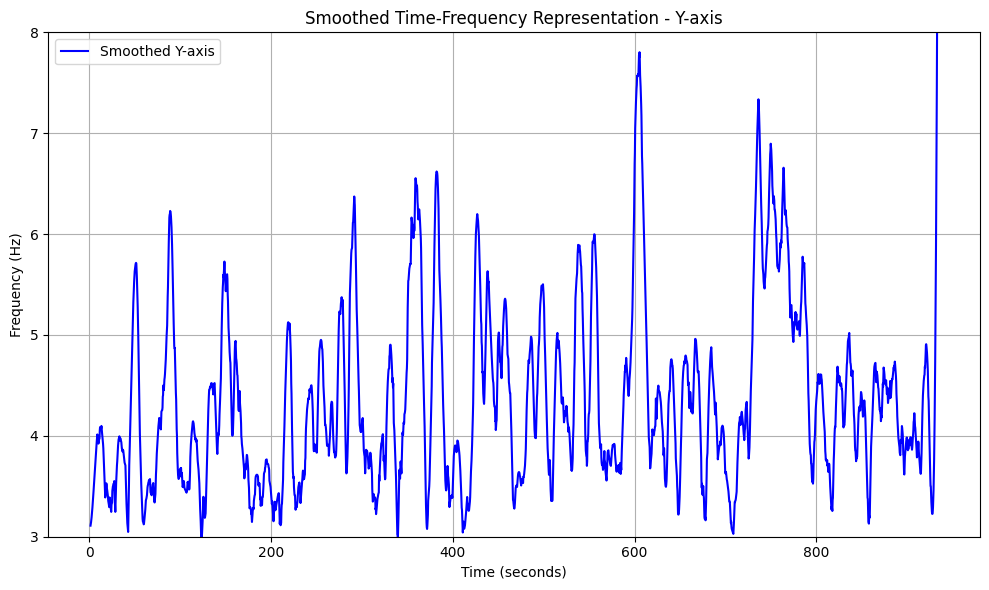

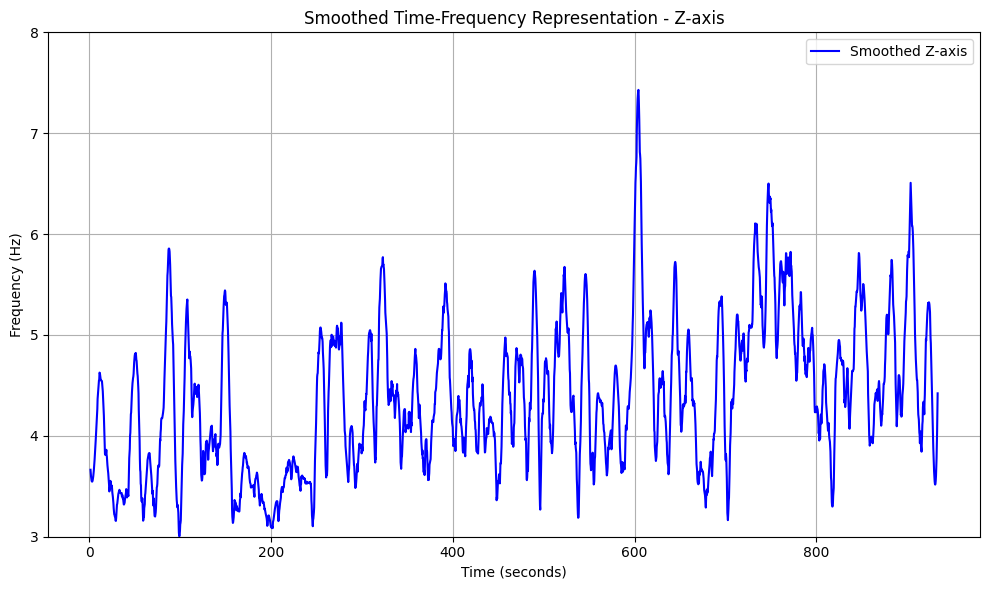

In [ ]:
from scipy.signal import savgol_filter

def smooth_time_frequency_per_axis(time_bins, dominant_frequencies_all_axes, window_length, polyorder):
    """
    Smooths the dominant frequencies for each axis using a Savitzky-Golay filter.

    Args:
        time_bins: Array of time bins.
        dominant_frequencies_all_axes: 2D array where each row corresponds to one axis (e.g., X, Y, Z).
        window_length: Length of the Savitzky-Golay filter window (must be odd).
        polyorder: Polynomial order for the Savitzky-Golay filter.

    Returns:
        smoothed_frequencies: 2D array of smoothed dominant frequencies for each axis.
    """
    smoothed_frequencies = []

    for dominant_frequencies in dominant_frequencies_all_axes:
        # Check if the window length is valid for this axis
        if len(dominant_frequencies) < window_length:
            raise ValueError(
                f"Window length {window_length} is too large for the data size {len(dominant_frequencies)}"
            )

        # Apply Savitzky-Golay filter
        smoothed = savgol_filter(dominant_frequencies, window_length, polyorder)
        smoothed_frequencies.append(smoothed)

    return np.array(smoothed_frequencies)

# Parameters for smoothing
window_length = 51  # Must be odd and smaller than the length of the time series
polyorder = 3  # Degree of polynomial for smoothing

# Assuming `time_bins` and `dominant_frequencies_all_axes` are available
smoothed_dominant_frequencies = smooth_time_frequency_per_axis(
    time_bins, dominant_frequencies_all_axes, window_length, polyorder
)

# Visualization for each axis
axis_labels = ['X-axis', 'Y-axis', 'Z-axis']
for i, label in enumerate(axis_labels):
    plt.figure(figsize=(10, 6))
    plt.plot(time_bins, smoothed_dominant_frequencies[i], label=f"Smoothed {label}", color="blue")
    plt.title(f"Smoothed Time-Frequency Representation - {label}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Frequency (Hz)")
    plt.ylim(3, 8)  # Focus on tremor range
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


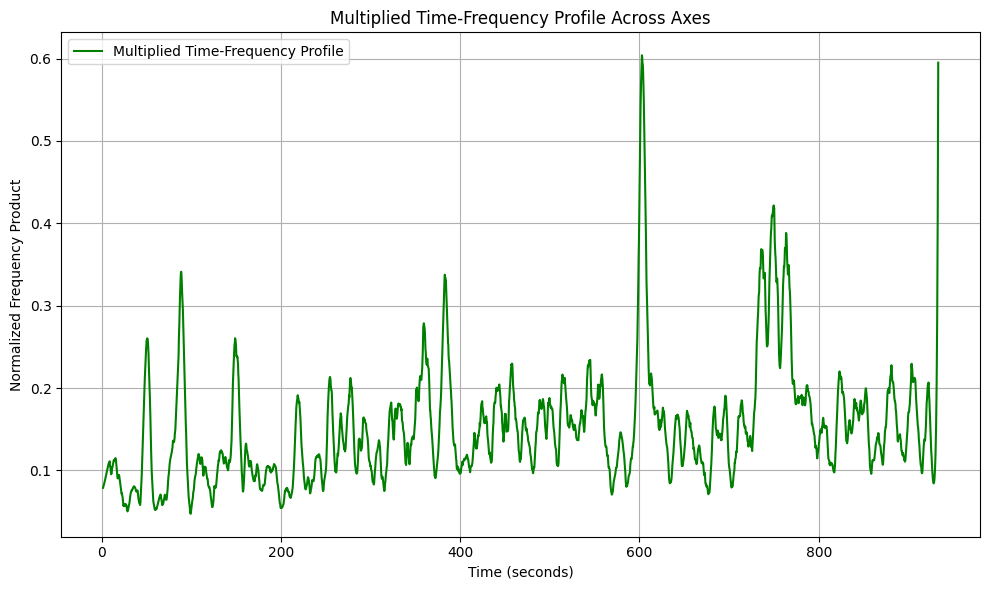

In [ ]:
# I added this stpe following the paper, because apparently in the paper it just combines it all, idk why
def multiply_smoothed_axes(smoothed_frequencies):
    """
    Multiplies smoothed time-frequency profiles across X, Y, and Z axes.

    Args:
        smoothed_frequencies: 2D array of smoothed frequencies for each axis (rows correspond to X, Y, Z).

    Returns:
        multiplied_profile: 1D array of the multiplied time-frequency profile across axes.
    """
    # Normalize frequencies for numerical stability
    normalized_frequencies = smoothed_frequencies / np.max(smoothed_frequencies, axis=1, keepdims=True)

    # Multiply across axes
    multiplied_profile = np.prod(normalized_frequencies, axis=0)

    return multiplied_profile

# Apply multiplication
multiplied_profile = multiply_smoothed_axes(smoothed_dominant_frequencies)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(time_bins, multiplied_profile, label="Multiplied Time-Frequency Profile", color="green")
plt.title("Multiplied Time-Frequency Profile Across Axes")
plt.xlabel("Time (seconds)")
plt.ylabel("Normalized Frequency Product")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


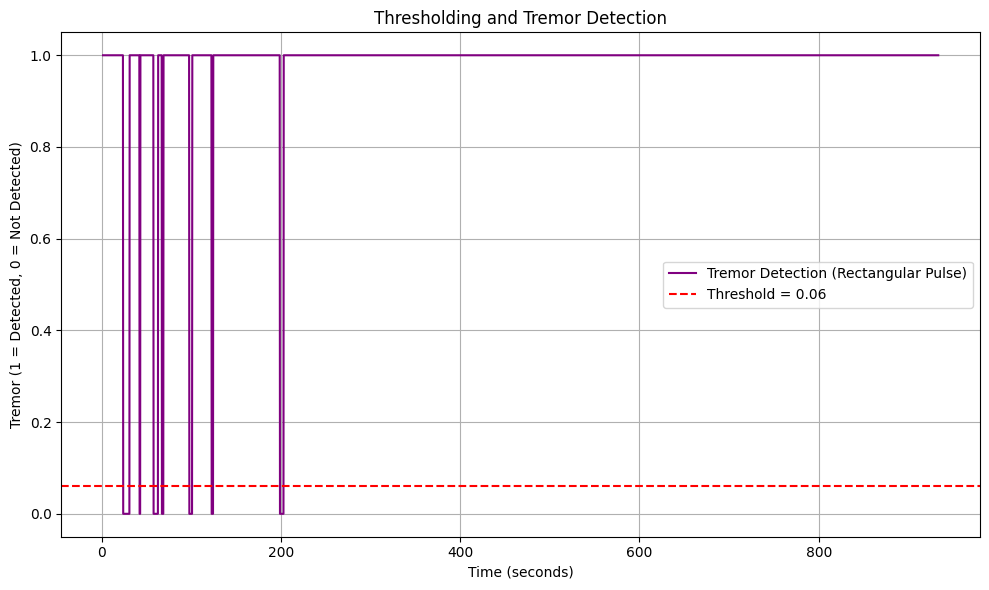

In [ ]:
def apply_threshold_and_detect_tremor(multiplied_profile, time_bins, threshold=None):
    """
    Applies a dynamic threshold to the multiplied profile and generates a rectangular pulse for tremor detection.

    Args:
        multiplied_profile: 1D array of multiplied time-frequency profile.
        time_bins: 1D array of time values corresponding to the profile.
        threshold: Optional; Frequency threshold for detecting tremor events.
                   If None, the threshold is dynamically calculated as max(profile) / 10.

    Returns:
        tremor_pulse: 1D array with 1 (tremor detected) or 0 (no tremor).
    """
    # Validation
    if len(multiplied_profile) != len(time_bins):
        raise ValueError("The multiplied_profile and time_bins must have the same length.")

    # Calculate dynamic threshold if not provided
    if threshold is None:
        threshold = np.max(multiplied_profile) / 10

    # Apply threshold
    tremor_pulse = (multiplied_profile > threshold).astype(int)

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(time_bins, tremor_pulse, label="Tremor Detection (Rectangular Pulse)", color="purple")
    plt.axhline(y=threshold, color="red", linestyle="--", label=f"Threshold = {threshold:.2f}")
    plt.title("Thresholding and Tremor Detection")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Tremor (1 = Detected, 0 = Not Detected)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return tremor_pulse

# Apply threshold and generate rectangular pulse
tremor_pulse = apply_threshold_and_detect_tremor(multiplied_profile, time_bins)


We need to revise the time-frequency representation

Detected Tremor Events:
Tremor detected from 1.50s to 24.00s (Duration: 22.50s)
Tremor detected from 31.20s to 42.30s (Duration: 11.10s)
Tremor detected from 43.20s to 57.90s (Duration: 14.70s)
Tremor detected from 63.00s to 67.20s (Duration: 4.20s)
Tremor detected from 69.00s to 97.80s (Duration: 28.80s)
Tremor detected from 101.10s to 122.70s (Duration: 21.60s)
Tremor detected from 124.50s to 198.90s (Duration: 74.40s)
Tremor detected from 203.10s to 933.30s (Duration: 730.20s)


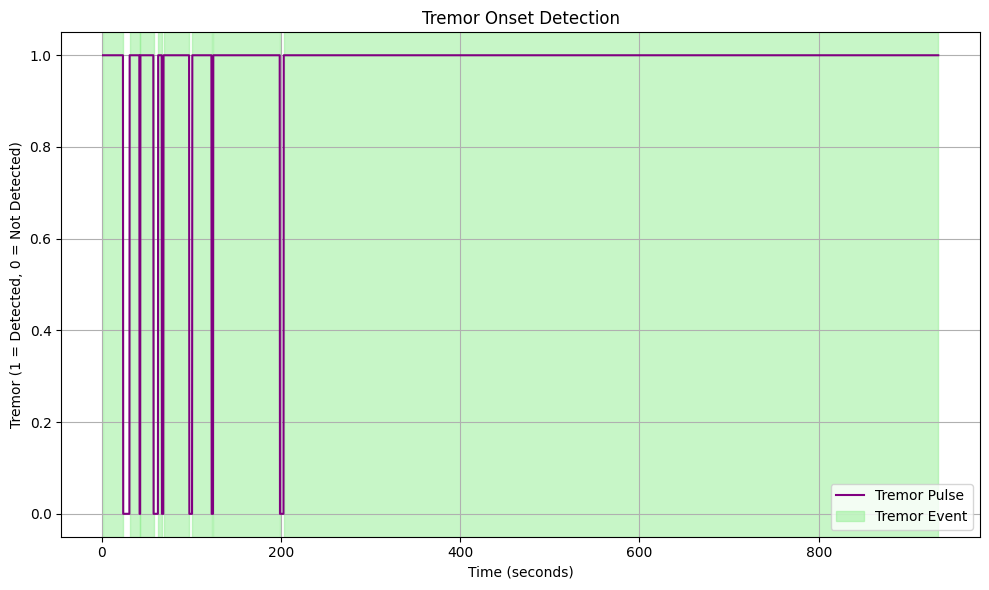

In [ ]:
# Tremor Onset Detection

def detect_tremor_onsets(tremor_pulse, time_bins, min_duration=3):
    """
    Detects the start and end times of tremor events from the rectangular pulse.

    Args:
        tremor_pulse: 1D array of 1s (tremor detected) and 0s (no tremor).
        time_bins: 1D array of time values corresponding to the pulse.
        min_duration: Minimum duration (in seconds) for a valid tremor.

    Returns:
        tremor_events: List of tuples [(start_time, end_time), ...] for valid tremor events.
    """
    tremor_events = []
    is_tremor = False
    start_time = None

    for i in range(len(tremor_pulse)):
        if tremor_pulse[i] == 1 and not is_tremor:
            # Start of a new tremor event
            is_tremor = True
            start_time = time_bins[i]

        elif tremor_pulse[i] == 0 and is_tremor:
            # End of a tremor event
            is_tremor = False
            end_time = time_bins[i]

            # Check if duration is greater than the minimum required
            if (end_time - start_time) >= min_duration:
                tremor_events.append((start_time, end_time))

    # Handle case where tremor ends at the last sample
    if is_tremor and (time_bins[-1] - start_time) >= min_duration:
        tremor_events.append((start_time, time_bins[-1]))

    return tremor_events


# Example Usage
min_duration = 3  # Minimum tremor duration in seconds
tremor_events = detect_tremor_onsets(tremor_pulse, time_bins, min_duration)

# Print detected tremor events
print("Detected Tremor Events:")
for start, end in tremor_events:
    print(f"Tremor detected from {start:.2f}s to {end:.2f}s (Duration: {end - start:.2f}s)")

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(time_bins, tremor_pulse, label="Tremor Pulse", color="purple")
for start, end in tremor_events:
    plt.axvspan(start, end, color="lightgreen", alpha=0.5, label="Tremor Event")
plt.title("Tremor Onset Detection")
plt.xlabel("Time (seconds)")
plt.ylabel("Tremor (1 = Detected, 0 = Not Detected)")
plt.legend(["Tremor Pulse", "Tremor Event"])
plt.grid(True)
plt.tight_layout()
plt.show()


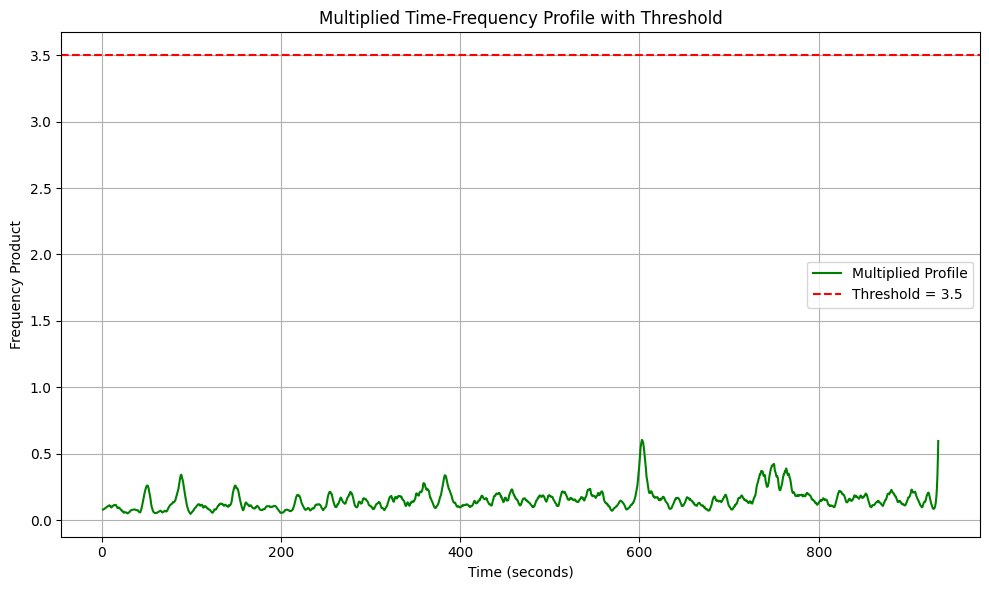

In [ ]:
# Visualize the multiplied profile with the threshold
plt.figure(figsize=(10, 6))
plt.plot(time_bins, multiplied_profile, label="Multiplied Profile", color="green")
plt.axhline(y=threshold, color='red', linestyle='--', label=f"Threshold = {threshold}")
plt.title("Multiplied Time-Frequency Profile with Threshold")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency Product")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


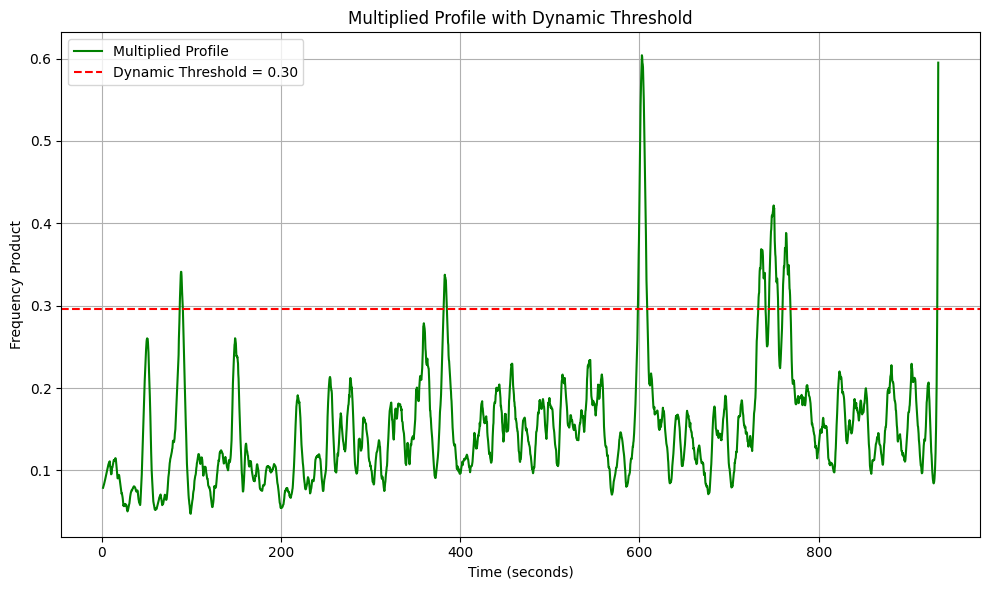

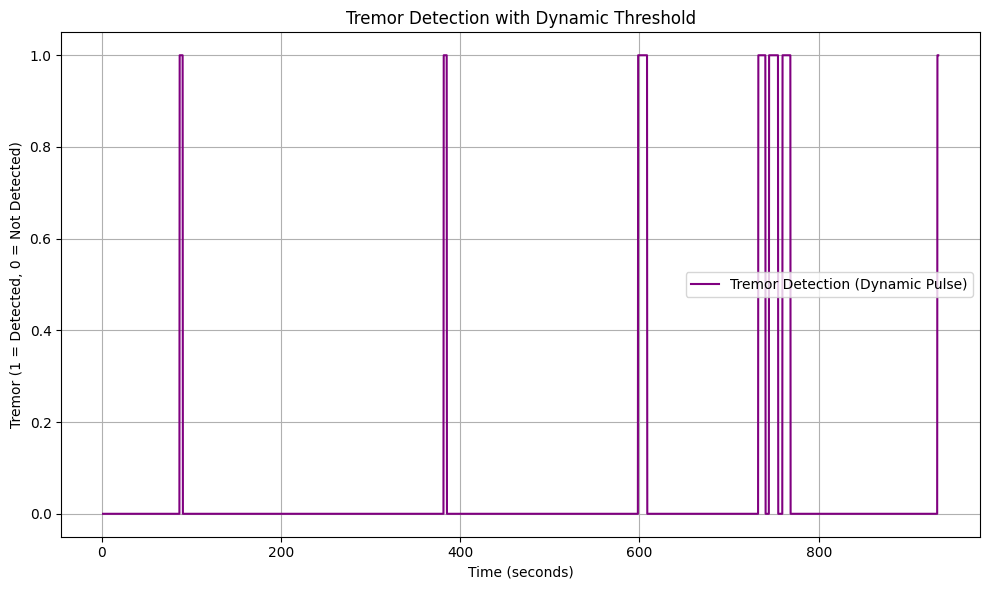

In [ ]:
# Compute a dynamic threshold based on the mean and standard deviation
threshold_dynamic = np.mean(multiplied_profile) + 2 * np.std(multiplied_profile)

# Apply dynamic threshold and visualize
plt.figure(figsize=(10, 6))
plt.plot(time_bins, multiplied_profile, label="Multiplied Profile", color="green")
plt.axhline(y=threshold_dynamic, color='red', linestyle='--', label=f"Dynamic Threshold = {threshold_dynamic:.2f}")
plt.title("Multiplied Profile with Dynamic Threshold")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency Product")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Update tremor detection with dynamic threshold
tremor_pulse_dynamic = (multiplied_profile > threshold_dynamic).astype(int)

# Visualize tremor pulse
plt.figure(figsize=(10, 6))
plt.plot(time_bins, tremor_pulse_dynamic, label="Tremor Detection (Dynamic Pulse)", color="purple")
plt.title("Tremor Detection with Dynamic Threshold")
plt.xlabel("Time (seconds)")
plt.ylabel("Tremor (1 = Detected, 0 = Not Detected)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


8. Feature Extraction and Thresholding -> This is not right, we need to revise why the cumulative time-frequency data is way below the threshold that the paper is using which was 3.5Hz. Because of this, when we apply the 3 seconds filter, it is saying that the patient is having tremor 100% of the time which is not realistic.

In [ ]:
# Extracts meaningful features (e.g., peak frequencies) and applies thresholds to differentiate tremor events from noise or non-tremor movements.

from scipy.signal import find_peaks
import numpy as np

def extract_features_and_classify(signal, fs, tremor_range=(3, 8), amplitude_threshold=10000, power_threshold=50):
    """
    Extracts features from the smoothed signal and classifies segments as tremor or non-tremor.

    Args:
        signal: 1D array, the smoothed signal.
        fs: Sampling frequency in Hz.
        tremor_range: Tuple (low_freq, high_freq), the frequency range for tremor detection.
        amplitude_threshold: Threshold for classifying tremor based on amplitude.
        power_threshold: Threshold for classifying tremor based on power.

    Returns:
        results: List of dictionaries containing features and classification for each segment.
    """
    segment_length = fs * 2  # Segment length of 2 seconds
    results = []

    # Divide the signal into segments
    num_segments = len(signal) // segment_length
    for i in range(num_segments):
        segment = signal[i * segment_length: (i + 1) * segment_length]

        # Compute FFT for the segment
        N = len(segment)
        freq_bins = np.fft.fftfreq(N, d=1/fs)
        fft_values = np.fft.fft(segment)
        power_spectrum = np.abs(fft_values) ** 2

        # Filter the power spectrum for the tremor range
        valid_indices = np.where((freq_bins >= tremor_range[0]) & (freq_bins <= tremor_range[1]))
        power_filtered = power_spectrum[valid_indices]
        freq_filtered = freq_bins[valid_indices]

        # Feature 1: Peak frequency
        if len(power_filtered) > 0:
            peak_index = np.argmax(power_filtered)
            peak_frequency = freq_filtered[peak_index]
            mean_power = np.mean(power_filtered)  # Feature 2: Mean power
        else:
            peak_frequency = None
            mean_power = 0

        # Feature 3: Maximum amplitude in the segment
        max_amplitude = np.max(np.abs(segment))

        # Classification based on thresholds
        if mean_power > power_threshold and max_amplitude > amplitude_threshold:
            classification = "Tremor"
        else:
            classification = "Non-Tremor"

        # Append results for this segment
        results.append({
            "Segment": i,
            "Peak Frequency": peak_frequency,
            "Mean Power": mean_power,
            "Max Amplitude": max_amplitude,
            "Classification": classification
        })

    return results

# Example signal and parameters
fs = 100  # Sampling frequency (Hz)
tremor_range = (3, 8)  # Tremor frequency range (Hz)
amplitude_threshold = 10000  # Example threshold for amplitude
power_threshold = 50  # Example threshold for mean power

# Extract features and classify
results = extract_features_and_classify(smoothed_signal, fs, tremor_range, amplitude_threshold, power_threshold)

# Print results for each segment
for result in results:
    print(result)


{'Segment': 0, 'Peak Frequency': 3.0, 'Mean Power': 6472717675.493478, 'Max Amplitude': 43209.65690086854, 'Classification': 'Tremor'}
{'Segment': 1, 'Peak Frequency': 3.0, 'Mean Power': 21921037684.805485, 'Max Amplitude': 28560.09801090359, 'Classification': 'Tremor'}
{'Segment': 2, 'Peak Frequency': 3.0, 'Mean Power': 35926052101.86746, 'Max Amplitude': 33792.77032678734, 'Classification': 'Tremor'}
{'Segment': 3, 'Peak Frequency': 3.0, 'Mean Power': 12904006201.508516, 'Max Amplitude': 30563.602174340085, 'Classification': 'Tremor'}
{'Segment': 4, 'Peak Frequency': 4.0, 'Mean Power': 5608204001.445593, 'Max Amplitude': 26571.103465895234, 'Classification': 'Tremor'}
{'Segment': 5, 'Peak Frequency': 3.0, 'Mean Power': 8459404346.844773, 'Max Amplitude': 20420.877598807812, 'Classification': 'Tremor'}
{'Segment': 6, 'Peak Frequency': 3.0, 'Mean Power': 6649042930.315192, 'Max Amplitude': 16678.32852491325, 'Classification': 'Tremor'}
{'Segment': 7, 'Peak Frequency': 3.0, 'Mean Power'

# EEG data

In [ ]:
# Filtering
# Define moving avergae filter
def moving_average_filter(data, window_size):
  b = np.ones(window_size) / window_size
  a = [1]
  return lfilter(b, a, data)

# Define bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, numtaps=101):
    taps = firwin(numtaps, [lowcut, highcut], pass_zero=False, fs=fs)
    filtered_data = lfilter(taps, 1.0, data)
    return filtered_data

# Define data segmentation
def segment_data(data, fs, overlap):

  window_size = int(3 * fs)
  step_size = int(window_size * (1 - overlap))
  num_windows = (len(data) - window_size) // step_size + 1
  hamming_window = hamming(window_size)
  segments = np.array([data[i:i + window_size] * hamming_window for i in range(0, len(data) - window_size + 1, step_size)])

  return segments

In [ ]:
# apply filters and segmentation to each axis in data
# store transformed data into a numpy array

acc_data = []
for axis in accelerometer_data:

  axis = moving_average_filter(axis, window_size = 100)
  axis = bandpass_filter(axis, lowcut=1, highcut=30, fs=500, numtaps=101)
  axis = segment_data(axis, fs = 500, overlap=0.9)
  acc_data.append(axis)

acc_data = np.array(acc_data)

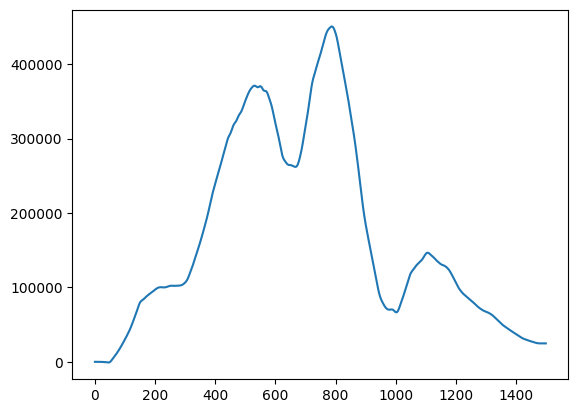

In [ ]:
# plot sample window
x = list(range(1500))
plt.plot(x, acc_data[0][0])

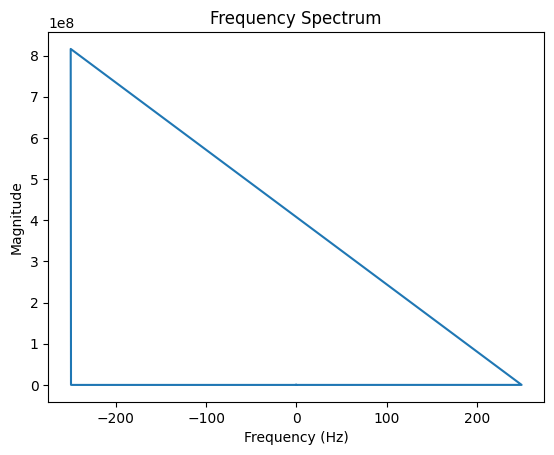

In [ ]:
# plot frequency spectrum for sample window
window = acc_data[1][3]

# create frequency spectrum
ar_coeffs,_,_ = aryule(window, 6)
psd = arma2psd(ar_coeffs, NFFT = len(window), sides = 'centerdc') # y-values
freq = np.fft.fftfreq(len(psd), d=1/500) # x-values

# plot spectrum
plt.plot(freq, psd)
plt.title("Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

In [ ]:
#4
def label(window, sampling_frequency = 500, tremor_min_freq = 3, tremor_max_freq = 8, ar_order = 6):

  labelled_windows = []

  # create frequency spectrum
  ar_coeffs,_,_ = aryule(window, ar_order)
  psd = arma2psd(ar_coeffs, NFFT = len(window)) # y-values
  psd = np.abs(psd)
  freq = np.fft.fftfreq(window.shape[0], d=1/sampling_frequency) # x-values


  # locate index of tallest peak
  peak_idx,_ = find_peaks(psd) # index of all peaks
  peak_heights = psd[peak_idx] # height of all peaks

  if len(peak_idx) == 0:
    return [1]

  tallest_peak_index = np.argmax(peak_heights)
  tallest_peak_freq = freq[tallest_peak_index] # frequency corresponding to tallest peak

  # compute threshhold
  T = peak_heights[tallest_peak_index] / 10

  # append window-label pair to list
  if (3 <= tallest_peak_freq <= 8) and (T):
    label = 0
    labelled_windows.append((window,label))
  else:
    label = 1
    labelled_windows.append((window,label))

  return labelled_windows

In [ ]:
#5
def dominant_peaks(window, sampling_frequency = 500, tremor_min_freq = 3, tremor_max_freq = 8, ar_order = 6):

  # create frequency spectrum
  ar_coeffs, _, _ = aryule(window, 6)
  psd = arma2psd(ar_coeffs, NFFT=len(window), sides='centerdc') # y-values
  psd = np.abs(psd)
  freq = np.fft.fftfreq(window.shape[0], d=1/sampling_frequency) # x-values


  # locate index of tallest peak
  peak_idx,_ = find_peaks(psd) # index of all peaks
  peak_heights = psd[peak_idx] # height of all peaks


  tallest_peak_index = np.argmax(peak_heights)
  tallest_peak_freq = freq[tallest_peak_index] # frequency corresponding to tallest peak


  # compute threshhold
  T = peak_heights[tallest_peak_index] / 10

  # obtain dominant peak
  if (3 <= tallest_peak_freq <= 8):
    dominant_peak = tallest_peak_freq
  else:
    dominant_peak = 1

  return dominant_peak

In [ ]:
for axis in acc_data:
  axis_peaks = [] # stores dominant peaks of all axis
  for window in axis:
    window_peaks = [] # stores dominant peak of each window in axis
    peaks = dominant_peaks(window)
    window_peaks.append(peaks)
    print(window_peaks)
  axis_peaks.append(window_peaks)

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


# EEG

In [ ]:
# access eeg data for one trial
eeg_file_path = '/content/drive/My Drive/NeuroTechUofT24/eeg_data/801_2_PD_REST-epo.fif'

# load the data
raw = mne.io.read_raw_fif(eeg_file_path, preload=True)

Opening raw data file /content/drive/My Drive/NeuroTechUofT24/eeg_data/801_2_PD_REST-epo.fif...


<ipython-input-17-90a01490abce>:5: RuntimeWarning: This filename (/content/drive/My Drive/NeuroTechUofT24/eeg_data/801_2_PD_REST-epo.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file_path, preload=True)


Isotrak not found
    Range : 0 ... 87000 =      0.000 ...   174.000 secs
Ready.
Reading 0 ... 87000  =      0.000 ...   174.000 secs...


Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


<ipython-input-18-e6057b300350>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()


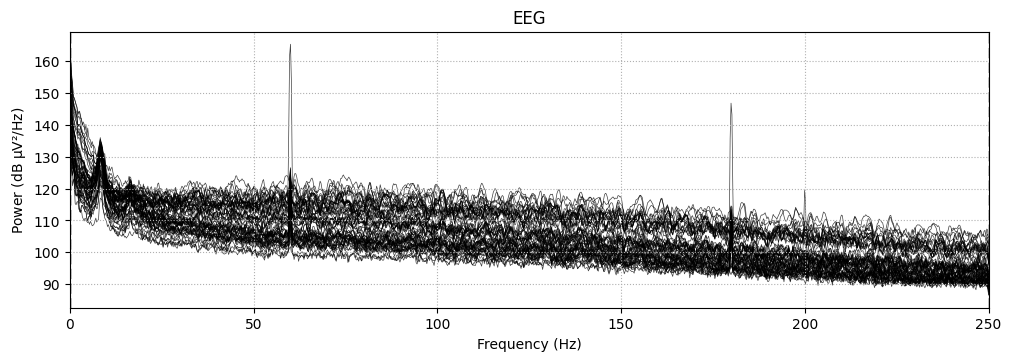

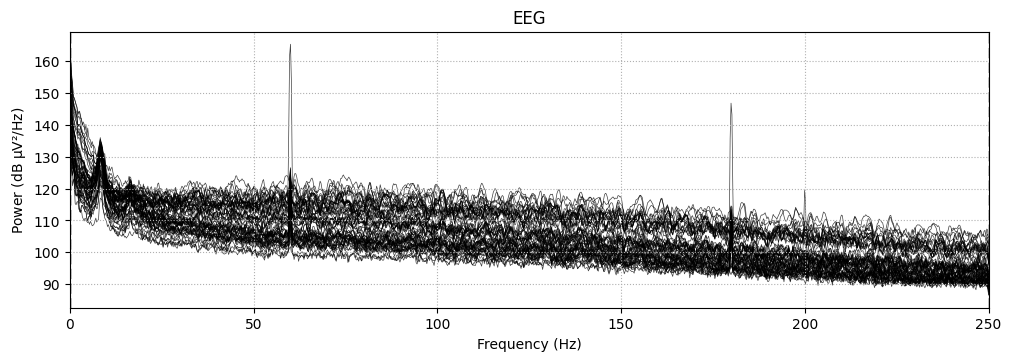

In [ ]:
raw.compute_psd().plot()

Using matplotlib as 2D backend.


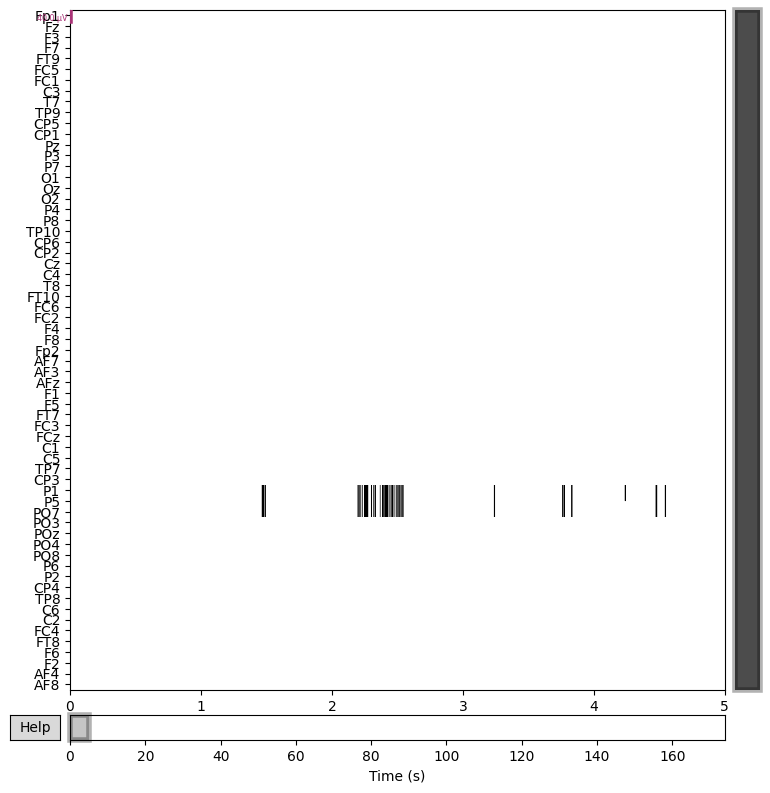

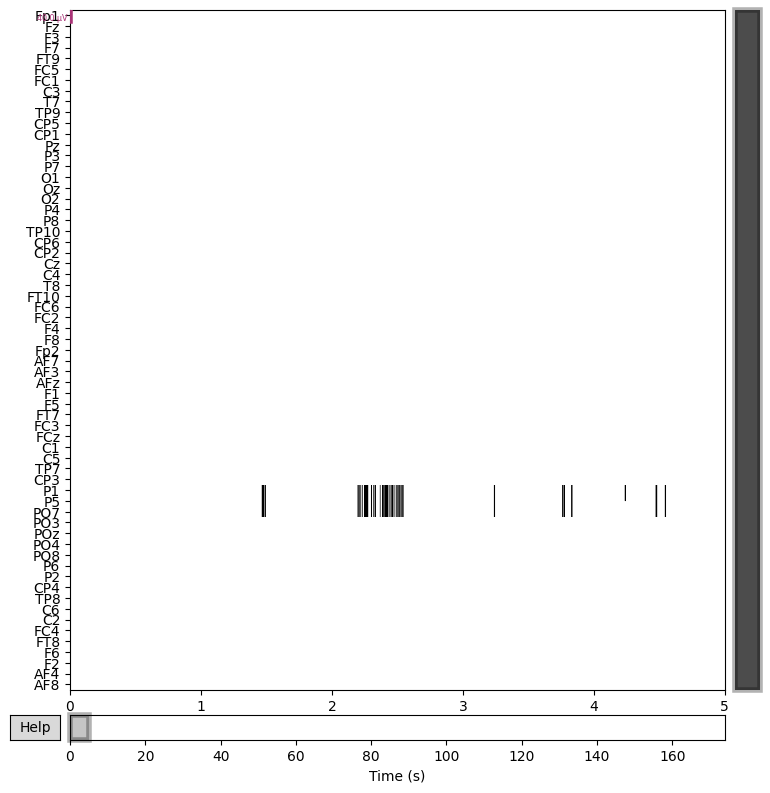

In [ ]:
raw.plot(duration=5, proj=False, n_channels=len(raw.ch_names), remove_dc=False)

In [ ]:
# bandpass filtering
raw.filter(l_freq=1.0, h_freq=40.0)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


<Raw | 801_2_PD_REST-epo.fif, 63 x 87001 (174.0 s), ~41.9 MiB, data loaded>

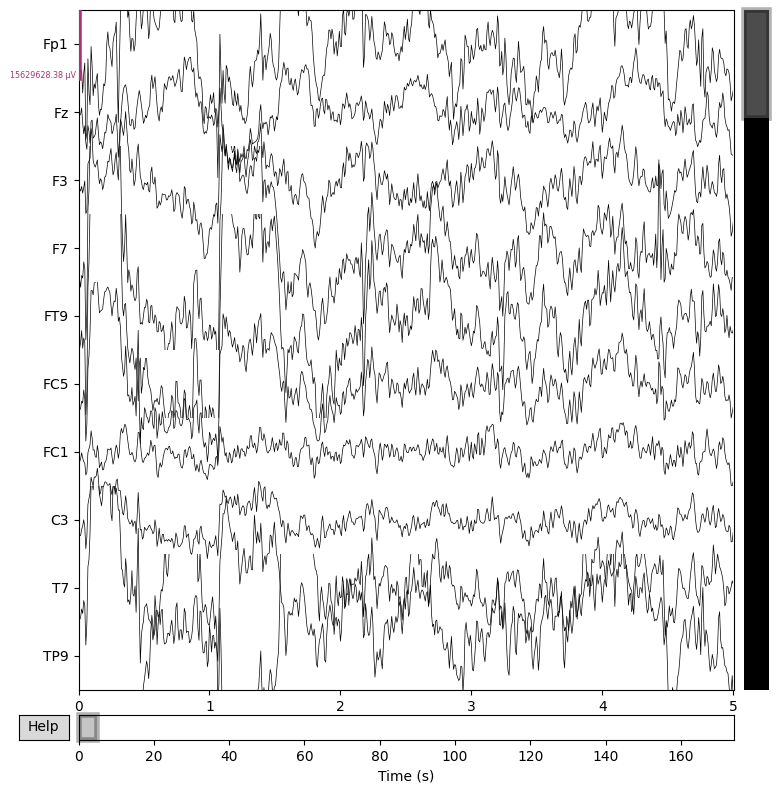

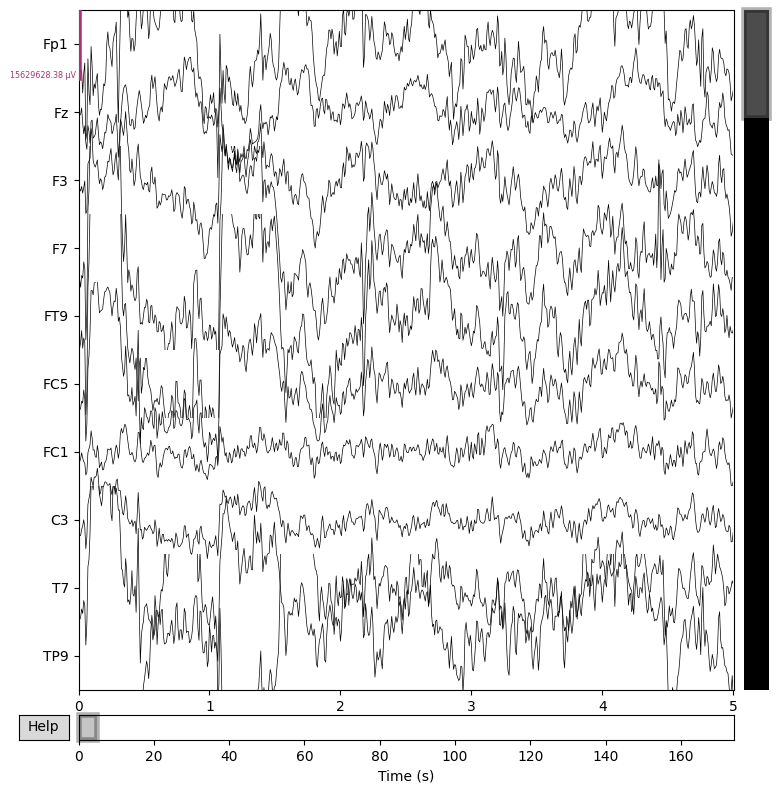

In [ ]:
raw.plot(n_channels=10, duration=5, remove_dc = True, scalings='auto')

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 7.8s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated


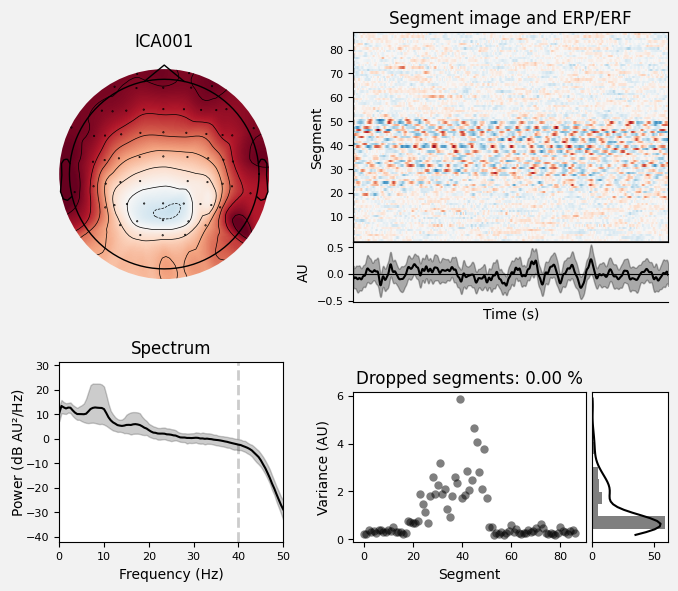

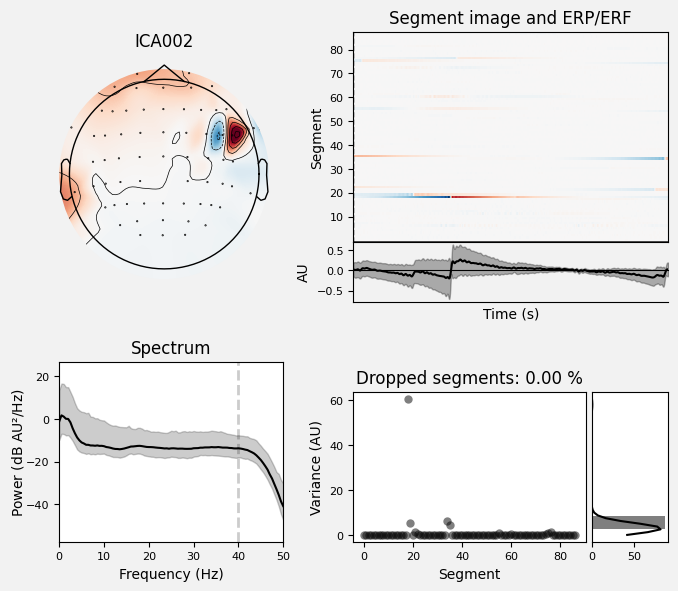

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [ ]:
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
# pick some random components, see https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#tut-artifact-ica for how to really
# choose the best components to exclude for our data when applying ICA
ica.exclude = [1, 2]
ica.plot_properties(raw, picks=ica.exclude)

# New Section

1.


In [ ]:
from scipy.signal import lfilter

def moving_average_filter(data, window_size=100):
    b = [1.0 / window_size] * window_size
    a = 1
    return lfilter(b, a, data)

for i in range(saved_eeg_data.shape[0]):
    saved_eeg_data[i, :] = moving_average_filter(saved_eeg_data[i, :], window_size=500)


NameError: name 'saved_eeg_data' is not defined

2.

In [ ]:
from scipy.signal import firwin, filtfilt

def bandpass_filter(data, lowcut=1, highcut=30, fs=500, order=100):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b = firwin(order + 1, [low, high], pass_zero=False)
    return filtfilt(b, [1.0], data)

for i in range(saved_eeg_data.shape[0]):
    saved_eeg_data[i, :] = bandpass_filter(saved_eeg_data[i, :])

3.

In [ ]:
from scipy.signal import hamming

def segment_data(data, window_size=1500, overlap=0.9, fs=500):
    step_size = int(window_size * (1 - overlap))
    segments = []
    for start in range(0, data.shape[1] - window_size + 1, step_size):
        segment = data[:, start:start + window_size] * hamming(window_size)
        segments.append(segment)
    return np.array(segments)

segmented_data = segment_data(saved_eeg_data)

4.

In [ ]:
#4
from spectrum import aryule, arma2psd
import numpy as np

def estimate_tremor(window, fs=100, low_freq=3, high_freq=8, ar_order=6):
    # Berg's method
    ar_coeffs, _, _ = aryule(window, ar_order)

    #Compute the power spectral density (PSD) from AR coefficients
    psd = arma2psd(ar_coeffs, sides='centerdc')

    # Convert PSD to frequencies
    freq_bins = np.fft.fftfreq(len(psd), d=1/fs)  # Generate frequency bins
    psd = np.abs(psd)  # Ensure PSD values are positive

    # Select frequencies in the range (3–8 Hz)
    tremor_indices = np.where((freq_bins >= low_freq) & (freq_bins <= high_freq))[0]
    freqs = freq_bins[tremor_indices]
    psd_tremor = psd[tremor_indices]

    return freqs, psd_tremor


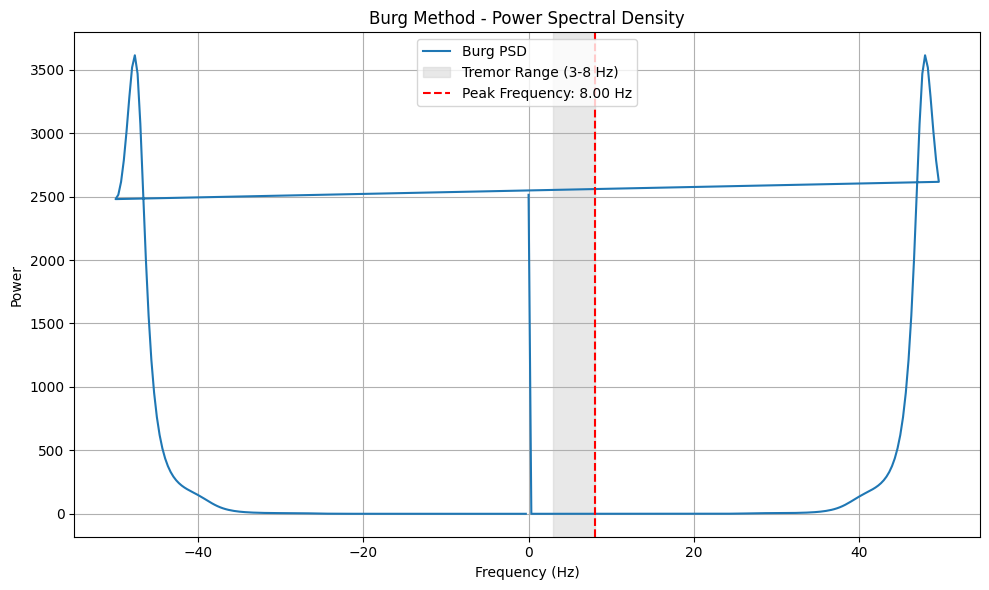

Detected Peak Frequency: 8.00 Hz


In [ ]:
from spectrum import aryule, arma2psd
import numpy as np
import matplotlib.pyplot as plt

# Example signal processing and plotting
fs = 100  # Sampling frequency in Hz
low_freq = 3
high_freq = 8
ar_order = 6

# Use one of your Hamming-windowed segments as the input
window = segmented_signal[0]  # Replace with a real segment

# Step 1: Estimate autoregressive coefficients using Burg method
ar_coeffs, _, _ = aryule(window, ar_order)

# Step 2: Compute power spectral density (PSD) from AR coefficients
psd = arma2psd(ar_coeffs, NFFT=len(window), sides='centerdc')
psd = np.abs(psd)  # Ensure PSD is non-negative

# Step 3: Generate corresponding frequency bins
freq_bins = np.fft.fftfreq(len(psd), d=1/fs)

# Step 4: Filter PSD and frequencies to focus on the 3–8 Hz range
valid_indices = np.where((freq_bins >= low_freq) & (freq_bins <= high_freq))
psd_filtered = psd[valid_indices]
freq_filtered = freq_bins[valid_indices]

# Step 5: Find the peak frequency in the filtered PSD
if len(psd_filtered) > 0:
    peak_index = np.argmax(psd_filtered)
    peak_frequency = freq_filtered[peak_index]

    # Step 6: Plot the PSD and mark the peak frequency
    plt.figure(figsize=(10, 6))
    plt.plot(freq_bins, psd, label="Burg PSD")
    plt.axvspan(low_freq, high_freq, color='lightgray', alpha=0.5, label="Tremor Range (3-8 Hz)")
    plt.axvline(peak_frequency, color='red', linestyle='--', label=f"Peak Frequency: {peak_frequency:.2f} Hz")
    plt.title("Burg Method - Power Spectral Density")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Detected Peak Frequency: {peak_frequency:.2f} Hz")
else:
    print("No peak frequency detected in the 3–8 Hz range.")
